# Sensitivity of Query Filters

In here, we'll look at how sensitive the query results are to the filters in the query.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

import sys
sys.path.append('..')

from locate_cluster_outliers.src.data_queries import querySIMBAD, formatSIMBADtoGAIA, getGAIAKnownMembers
from locate_cluster_outliers.src.gaiastars import gaiastars as gs

import astropy.units as u

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Load up Stars, Cluster Info

In [2]:
known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']


In [3]:
#construct a dict mapping cluster name in Table1a to its name in Simabad
name_mapper = {'Hyades': 'Hyades',
               'Coma Berenices Cluster':'ComaBer',
               'Pleiades':'Pleiades',
               'Praesepe': 'Praesepe',
               'alpha Per':'alphaPer',
               'IC 2391': 'IC2391',
               'IC 2602': 'IC2602',
               'Blanco 1': 'Blanco1',
               'NGC 2451A': 'NGC2451'}
cluster_info = querySIMBAD(name_mapper, formatGaia=True)

In [4]:
#these need to be lists
constraints = {
    'baseline': ['{schema}.gaia_source.source_id >= 0'], # should always be true
    'parallax_error':['{schema}.gaia_source.parallax_over_error > 10'],
    'phot_flux_error': ['{schema}.gaia_source.phot_g_mean_flux_over_error>50 AND {schema}.gaia_source.phot_rp_mean_flux_over_error>20 AND {schema}.gaia_source.phot_bp_mean_flux_over_error>20'],
    'bp_rp_excess':['{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2) AND {schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)'],
    'vis_periods': ['{schema}.gaia_source.visibility_periods_used>8'],
    'astro_chi2_al': ['{schema}.gaia_source.astrometric_chi2_al/({schema}.gaia_source.astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*({schema}.gaia_source.phot_g_mean_mag-19.5)))']
}

In [5]:
[constraints[c][0].format(schema='gaiadr2') for c in constraints]

['gaiadr2.gaia_source.source_id >= 0',
 'gaiadr2.gaia_source.parallax_over_error > 10',
 'gaiadr2.gaia_source.phot_g_mean_flux_over_error>50 AND gaiadr2.gaia_source.phot_rp_mean_flux_over_error>20 AND gaiadr2.gaia_source.phot_bp_mean_flux_over_error>20',
 'gaiadr2.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power(gaiadr2.gaia_source.phot_bp_mean_mag-gaiadr2.gaia_source.phot_rp_mean_mag,2) AND gaiadr2.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power(gaiadr2.gaia_source.phot_bp_mean_mag-gaiadr2.gaia_source.phot_rp_mean_mag,2)',
 'gaiadr2.gaia_source.visibility_periods_used>8',
 'gaiadr2.gaia_source.astrometric_chi2_al/(gaiadr2.gaia_source.astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(gaiadr2.gaia_source.phot_g_mean_mag-19.5)))']

## Discussion on Constraints
### Baseline
The `gaiastars` object uses by default the filters below in its cone and box search methods. These filters all refer to columns in the `{schema}.gaia_source` table in the Gaia Archive.  The filters match those used in
[Gaia A](#GaiaA) by the Gaia Collaborative. See Appendix B in that paper. The display below shows these filters grouped by the concepts that they filter.
The `gaiastars` search methods append these filters as a `WHERE` clause on the `ADQL` query that it submits to the Gaia Archive.

The analysis that follows both imposes and relaxes these filters one group at a time. In the case of imposition, the baseline case has no filters, then each filter group is applied individually and the returned number of stars counted.
Conversely in the relaxation case, the baseline case includes all filters, then each filter is removed individually and the returned number of stars counted.

```sql
--parallax precision (parallax_error)
 parallax_over_error > 10

-- photometry precision (phot_flux_error)
AND  phot_g_mean_flux_over_error>50
    AND  phot_rp_mean_flux_over_error>20
    AND  phot_bp_mean_flux_over_error>20

--excess noise (bp_rp_error)
AND  phot_bp_rp_excess_factor < 1.3+0.06*power( phot_bp_mean_mag- phot_rp_mean_mag,2)
    AND  phot_bp_rp_excess_factor > 1.0+0.015*power( phot_bp_mean_mag- phot_rp_mean_mag,2)

-- visibility periods (vis_periods)
AND  visibility_periods_used>8

--astrometric chi square (astro_chi2_al)
AND  astrometric_chi2_al/( astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*( phot_g_mean_mag-19.5)))
```

The sections below discuss each filter group in turn.

### Parallax Over Error
This filter constrains the query to return only stars with high-precision parallax measurements.
`parallax_over_error` specifies that the error in measurement be at most 10% of the measured parallax.
This ensures accurate distance measurements which in turn ensures accurate estimation of the distance modulus and therefore absolute magnitude, via:

$$M_G = G + 5 + 5 log_{10}(\frac{\varpi}{1000})$$

where $\varpi$ is the parallax in milliarcseconds.

[Gaia A](#GaiaA) uses `parallax_over_error > 10` ; [Farias 2020](#Farias2020) uses `parallax_over_error > 5`

### Excess Noise
ADQL Code:
```
AND  phot_bp_rp_excess_factor < 1.3+0.06*power( phot_bp_mean_mag- phot_rp_mean_mag,2)
    AND  phot_bp_rp_excess_factor > 1.0+0.015*power( phot_bp_mean_mag- phot_rp_mean_mag,2)
```

Field Description from [Gaia DM](#GaiaDM):
**phot_bp_rp_excess_factor**:
>BP/RP excess factor estimated from the comparison of the sum of integrated BP and RP fluxes with respect to the flux in the G band. This measures the excess of flux in the BP and RP integrated photometry with respect to the G band. This excess is believed to be caused by background and contamination issues affecting the BP and RP data. Therefore a large value of this factor for a given source indicates systematic errors in the BP and RP photometry.

[Farias 2020](#Farias2020) states:
> We note that we have deliberately avoided to impose a photometric condition to clean the sample using `phot_bp_rp_excess factor`, given that there are many reasons why this factor may be high and would not directly affect the quality of astrometric solution.

[Schoettler 2020](#Schoettler2020) states:
>The photometric excess noise (flux excess factor E) filter
(Lindegren et al. 2018; Gaia Collaboration et al. 2018b):

>$
1.0 + 0.015(GBP − GRP)^2 <  \epsilon < 1.3 + 0.06(GBP − GRP)^2
$

>provides us with high-quality photometric data as well as
further cleaning up the astrometry (Arenou et al. 2018). This
filter removes sources with spurious photometry in dense, crowded areas (such as the centre of the ONC) (Lindegren
et al. 2018; Gaia Collaboration et al. 2018b). In our case, it
filters a large number of stars located in the central region
of the ONC, which does not greatly affect our analysis as
we are mainly interested in stars that are no longer in this
region.

which is what the `gaiastars` filter provides. Notice agreemeent between Schoettler and Gaia A.

### Phot_flux_error

ADQL Code:
```sql
AND  phot_g_mean_flux_over_error>50
    AND  phot_rp_mean_flux_over_error>20
    AND  phot_bp_mean_flux_over_error>20
```

Since the purpose of the Gaia paper was to produce clean HR diagrams, the authors desired to have high precision on the photometry of the stars they considered.

### vis_periods

`visibility_periods_used` captures the number of groups of observations that the data processing pipeline used in computing the astrometric values. The calculations require at least six visibility periods according to [Gaia A](#GaiaA).
`gaiastars` defaults this value  to 8, consistent with [Gaia A](#GaiaA).

[Farias 2020](#Farias2020) uses `visibility_periods_used > 6`, slightly more relaxed than [Gaia A](#GaiaA).

### astro_chi2_al
ADQL code:
```sql
AND  astrometric_chi2_al/( astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*( phot_g_mean_mag-19.5)))
```
Field descriptions from [Gaia DM](#GaiaDM):
- **astrometrtic_chi2_al**:
>Astrometric goodness-of-fit (χ2) in the AL direction.
>χ2 values were computed for the ‘good’ AL observations of the source, without taking into account the astrometric_excess_noise (if any) of the source. They do however take into account the attitude excess noise (if any) of each observation.

- **astrometric_n_good_obs_as**:
>Number of AL observations (= CCD transits) that were not strongly downweighted in the astrometric solution of the source. Strongly downweighted observations (with downweighting factor w<0.2) are instead counted in astrometric_n_bad_obs_al. The sum of astrometric_n_good_obs_al and astrometric_n_bad_obs_al equals
astrometric_n_obs_al, the total number of AL observations used in the astrometric solution of the source.

From [Gaia A](#GaiaA):
>When it is high, it either means that the astrometric solution has failed and/or that the studied object is in a multiple system for which the single-star solution is not reliable

### Reference Unit Weight Error (RUWE)

Curiously, [Gaia A](#GaiaA) omits this parameter from its queries, but [Farias 2020](#Farias2020) uses it to:
>First, to limit ourselves to stars with well-behaved astrometric solutions, we select those sources with reference
unit weight error (RUWE) parameter < 1.4.

From the data model description [Gaia DM](GaiaDM):
>This table contains the Renormalised Unit Weight Error (RUWE) associated to each source in gaia_source.
The RUWE is expected to be around 1.0 for sources where the single-star model provides a good fit to the astrometric observations. A value significantly greater than 1.0 (say, >1.4) could indicate that the source is non-single or otherwise problematic for the astrometric solution.

The Gaia Archive provides this value in a separate table names `rwue` which is indexed by `source_id`. It is not clear at the time of writing this whether the `rwue` table provides a RUWE value for each of the 1.7 B sources in `{schema}.gaia_source` (the main Gaia table)

[Schoettler 2020](#Schoettler2020) uses `ruwe <= 1.3`

## Query Adjustments

In [13]:
# adjust the returned columns, hopefully queries will run faster
default_columns = gs.gaia_column_dict_gaiadr2.copy()
cd = default_columns.copy()
cd.pop('external.gaiadr2_geometric_distance')
cd['gaiadr2.gaia_source'] = ['parallax'] #keep the return value simple
gs.gaia_column_dict_gaiadr2 = cd

## Imposed Constraints

Here we start with no constraints on the query and subsequently impose each constraint one at a time and count the number of records that the query returns.

In [7]:
cl = 'Pleiades'
ra_offset =  0*u.degree
dec_offset = 0*u.degree
search_radius = 5.0*u.degree

ra = cluster_info.loc[cl]['coords'].ra + ra_offset
dec = cluster_info.loc[cl]['coords'].dec + dec_offset

imposed_results = {}
for c in constraints:

    #grab some stars around the cluster center
    fs = gs(name=c, description=constraints[c])
    fs.set_gaia_source_constraints(constraints[c])

    fs.conesearch(ra, dec, search_radius, schema='gaiadr2')
    
    imposed_results[c] = {'tap_query_string': fs.tap_query_string,
                         'RecordsReturned': len(fs.objs)
                        } 
    print(fs)

INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: baseline, Description: ['{schema}.gaia_source.source_id >= 0'], 699677 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: parallax_error, Description: ['{schema}.gaia_source.parallax_over_error > 10'], 73459 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: phot_flux_error, Description: ['{schema}.gaia_source.phot_g_mean_flux_over_error>50 AND {schema}.gaia_source.phot_rp_mean_flux_over_error>20 AND {schema}.gaia_source.phot_bp_mean_flux_over_error>20'], 315816 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: bp_rp_excess, Description: ['{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2) AND {schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,

## Relaxed Constraints

Here we start with all constraints on the query and subsequently relax each constraint one at a time and count the number of records that the query returns.

In [8]:
cl = 'Pleiades'
ra_offset =  0*u.degree
dec_offset = 0*u.degree
search_radius = 5.0*u.degree

ra = cluster_info.loc[cl]['coords'].ra + ra_offset
dec = cluster_info.loc[cl]['coords'].dec + dec_offset

relaxed_results = {}
for c in constraints:
    
    my_constraints = constraints.copy()
    my_constraints.pop(c)
    query_constraints =[item for sublist in my_constraints for item in my_constraints[sublist]]

    #grab some stars around the cluster center
    fs = gs(name=f'Relaxed {c}', description=constraints[c])
    fs.set_gaia_source_constraints(query_constraints)

    fs.conesearch(ra, dec, search_radius, schema='gaiadr2')
    
    relaxed_results[c] = {'tap_query_string': fs.tap_query_string,
                         'RecordsReturned': len(fs.objs)
                        } 
    print(fs)

INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: Relaxed baseline, Description: ['{schema}.gaia_source.source_id >= 0'], 64605 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: Relaxed parallax_error, Description: ['{schema}.gaia_source.parallax_over_error > 10'], 273271 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: Relaxed phot_flux_error, Description: ['{schema}.gaia_source.phot_g_mean_flux_over_error>50 AND {schema}.gaia_source.phot_rp_mean_flux_over_error>20 AND {schema}.gaia_source.phot_bp_mean_flux_over_error>20'], 66895 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: Relaxed bp_rp_excess, Description: ['{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2) AND {schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema

In [9]:
constraints

{'baseline': ['{schema}.gaia_source.source_id >= 0'],
 'parallax_error': ['{schema}.gaia_source.parallax_over_error > 10'],
 'phot_flux_error': ['{schema}.gaia_source.phot_g_mean_flux_over_error>50 AND {schema}.gaia_source.phot_rp_mean_flux_over_error>20 AND {schema}.gaia_source.phot_bp_mean_flux_over_error>20'],
 'bp_rp_excess': ['{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2) AND {schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)'],
 'vis_periods': ['{schema}.gaia_source.visibility_periods_used>8'],
 'astro_chi2_al': ['{schema}.gaia_source.astrometric_chi2_al/({schema}.gaia_source.astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*({schema}.gaia_source.phot_g_mean_mag-19.5)))']}

In [10]:
[item for sublist in my_constraints for item in my_constraints[sublist]]

['{schema}.gaia_source.source_id >= 0',
 '{schema}.gaia_source.parallax_over_error > 10',
 '{schema}.gaia_source.phot_g_mean_flux_over_error>50 AND {schema}.gaia_source.phot_rp_mean_flux_over_error>20 AND {schema}.gaia_source.phot_bp_mean_flux_over_error>20',
 '{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2) AND {schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',
 '{schema}.gaia_source.visibility_periods_used>8']

In [11]:
[my_constraints[cons] for cons in my_constraints]

[['{schema}.gaia_source.source_id >= 0'],
 ['{schema}.gaia_source.parallax_over_error > 10'],
 ['{schema}.gaia_source.phot_g_mean_flux_over_error>50 AND {schema}.gaia_source.phot_rp_mean_flux_over_error>20 AND {schema}.gaia_source.phot_bp_mean_flux_over_error>20'],
 ['{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2) AND {schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)'],
 ['{schema}.gaia_source.visibility_periods_used>8']]

## Plot of Results

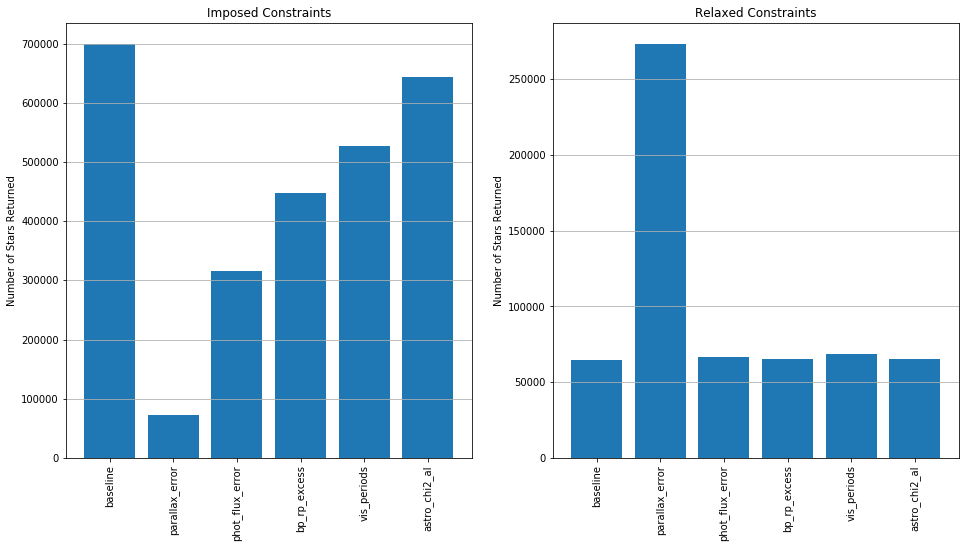

In [12]:

fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2)


y_pos = np.arange(len(imposed_results))
nrecords  = np.array([imposed_results[c]['RecordsReturned'] for c in constraints])

ax[0].bar(y_pos, nrecords,  align='center')
ax[0].set_xticks(y_pos)
ax[0].set_xticklabels([c for c in constraints], rotation=90)
#ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_ylabel('Number of Stars Returned')
ax[0].set_title('Imposed Constraints')
ax[0].grid(axis='y')



y_pos = np.arange(len(relaxed_results))
nrecords  = np.array([relaxed_results[c]['RecordsReturned'] for c in constraints])

ax[1].bar(y_pos, nrecords,  align='center')
ax[1].set_xticks(y_pos)
ax[1].set_xticklabels([c for c in constraints], rotation=90)
#ax[1].invert_yaxis()  # labels read top-to-bottom
ax[1].set_ylabel('Number of Stars Returned')
ax[1].set_title('Relaxed Constraints')
ax[1].grid(axis='y')

plt.show()


## Conclusions

Looks like parallax_over_error introduces the most severe constraint.
The Relaxed Constraint plot above shows that the other constraints make a marginal difference in the number of stars returned in conjunction with the parallax precision constraint.

In [4]:
from astropy.table import QTable, Table, vstack
table2 = pd.read_csv('~/Cas-Tau/data/2018A+A___616A__10G/Table2.csv')
table2.rename(columns={'Cluster':'cluster'}, inplace=True)

#need this as astropy table
table2_t = Table.from_pandas(table2)
table2_t.add_index('cluster')
table2_t[0:5]

cluster,DM,log_age,Fe_H,e_b_minus_v,NMembers
str8,float64,float64,float64,float64,int64
Hyades,3.389,8.9,0.13,0.001,480
ComaBer,4.669,8.81,0.0,0.0,127
Pleiades,5.667000000000001,8.04,-0.01,0.045,1059
IC2391,5.9079999999999995,7.7,-0.01,0.03,254
IC2602,5.914,7.6,-0.02,0.031,391


In [5]:
from astropy.table import join

# paste the table 2 data onto the cluster info table

#use default inner join join_type to eliminate cluster not of interest
cluster_info = join(cluster_info, table2_t)
cluster_info.add_index('cluster')

#put on the Z values (see Gaia Paper Section 6)
cluster_info['Z'] = 0.017
for cl in ['Praesepe','Hyades','alphaPer']:
    cluster_info.loc[cl]['Z'] = 0.020
    
cluster_info

typed_id,parallax,parallax_error,ra,ra_error,dec,dec_error,pmra,pmdec,radial_velocity,rv_error,cluster,coords,DM,log_age,Fe_H,e_b_minus_v,NMembers,Z
,mas,,"""h:m:s""",,"""d:m:s""",,mas / yr,mas / yr,km / s,km / s,,"deg,deg,pc",,,,,,
str22,float64,int16,str13,int16,str13,int16,float64,float64,float64,float32,str8,object,float64,float64,float64,float64,int64,float64
Blanco 1,4.216,3,00 04 07,4,-29 50.0,4,18.724,2.650,5.780,0.100,Blanco1,"1.029259593544724,-29.833321924337177,237.19174246002012",6.876,8.06,0.03,0.01,361,0.017
Coma Berenices Cluster,11.640,3,12 25 06.00,6,+26 06 00.0,6,-12.111,-8.996,-0.520,0.070,ComaBer,"186.27494193817012,26.099961269767117,85.91064467749707",4.669,8.81,0.0,0.0,127,0.017
Hyades,21.052,3,04 26 54.00,6,+15 52 00.0,6,104.920,-28.000,39.960,0.060,Hyades,"66.72546959401939,15.866546120181058,47.50205839190105",3.389,8.9,0.13,0.001,480,0.02
IC 2391,6.597,3,08 40 32,4,-53 02.0,4,-24.927,23.256,14.590,0.090,IC2391,"130.13315487316234,-53.033233209971144,151.5842846025466",5.9079999999999995,7.7,-0.01,0.03,254,0.017
IC 2602,6.571,3,10 42 58,4,-64 24.0,4,-17.783,10.655,17.430,0.110,IC2602,"160.74148947876645,-64.39995412731444,152.18411434540482",5.914,7.6,-0.02,0.031,391,0.017
NGC 2451A,5.165,3,07 43 12,4,-38 24.0,4,-21.116,15.328,27.700,0.500,NGC2451,"115.79988399825014,-38.39993400889923,193.61128124453285",6.433,7.78,-0.08,0.0,311,0.017
Pleiades,7.364,3,03 47 00,4,+24 07.0,4,19.997,-45.548,5.650,0.090,Pleiades,"56.75009432548025,24.11647057028541,135.7958527032827",5.667000000000001,8.04,-0.01,0.045,1059,0.017
Praesepe,5.371,3,08 40 24,4,+19 40.0,4,-36.047,-12.917,34.720,0.080,Praesepe,"130.09983519474272,19.666611055570947,186.18561824265458",6.35,8.85,0.16,0.027000000000000003,771,0.02


In [6]:
GETISOCHRONES = True

if GETISOCHRONES:
    #import the parsec class
    from ezpadova import parsec

    ## Get the Isochrone for Each Cluster, using Age and Z values from cluster_info (which are from Table 2)
    isochrones = {}
    for cl in cluster_names:
        c = cluster_info.loc[cl]
        a=10.0**c['log_age']
        iso = parsec.get_one_isochrone(a, c['Z'], model='parsec12s', phot='gaiaDR2')
        #just grab the photometry values
        isochrones[cl]= {'G_BP': iso['G_BP'],
                         'G_RP': iso['G_RP'],
                         'G':    iso['G']}

Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...


## Kounkel's Filters

1. $\sigma_\pi$ < 0.1 mas or $\sigma_\pi/\pi$ < 0.1,
2. 1.0857/phot_g_mean_flux_over_error < 0.03,
3. astrometric_sigma5d_max < 0.3,
4. visibility_periods_used > 8,
5. astrometric_excess_noise < 1 or
(astrometric_excess_noise> 1 and
astrometric_excess_noise_sig <2),
6. $V^{lsr}_{\alpha,\delta} < 60 km s^{-1}$

In [7]:
default_filter = [
		'{schema}.gaia_source.parallax_over_error > 10',
		'{schema}.gaia_source.phot_g_mean_flux_over_error>50',
		'{schema}.gaia_source.phot_rp_mean_flux_over_error>20',
		'{schema}.gaia_source.phot_bp_mean_flux_over_error>20',
		'{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',
		'{schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',
		'{schema}.gaia_source.visibility_periods_used>8',
		'{schema}.gaia_source.astrometric_chi2_al/({schema}.gaia_source.astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*({schema}.gaia_source.phot_g_mean_mag-19.5)))']

In [8]:
kounkel_constraints = [
    '{schema}.gaia_source.parallax_over_error > 10',
    '1.0857/{schema}.gaia_source.phot_g_mean_flux_over_error < 0.03',
    '{schema}.gaia_source.astrometric_sigma5d_max < 0.3',
    '{schema}.gaia_source.visibility_periods_used > 8',
    '(({schema}.gaia_source.astrometric_excess_noise < 1) or (({schema}.gaia_source.astrometric_excess_noise> 1) and ({schema}.gaia_source.astrometric_excess_noise_sig <2)))']

In [9]:
schoettler_constraints = [
    '(({schema}.gaia_source.astrometric_excess_noise < 1) or (({schema}.gaia_source.astrometric_excess_noise> 1) and ({schema}.gaia_source.astrometric_excess_noise_sig <2)))',
    '{schema}.ruwe.ruwe < 1.3'
]

In [10]:
farias_constraints = [
    '{schema}.gaia_source.parallax_over_error > 5',
    '{schema}.gaia_source.visibility_periods_used > 6',
    '{schema}.ruwe.ruwe < 1.4'
]

In [11]:
constraint_sets = {'default':default_filter, 'farias': farias_constraints, 'kounkel': kounkel_constraints, 'schoettler': schoettler_constraints}

In [14]:
cd = default_columns.copy()
#cd.pop('external.{schema}_geometric_distance') # ditch the left join with this table
cd['gaiadr2.ruwe'] = ['ruwe'] # but add this join
gs.gaia_column_dict_gaiadr2 = cd

In [15]:
cl = 'Pleiades'
ra_offset =  0*u.degree
dec_offset = 0*u.degree
search_radius = 5.0*u.degree
parallax=(6.25,10.0)

ra = cluster_info.loc[cl]['coords'].ra + ra_offset
dec = cluster_info.loc[cl]['coords'].dec + dec_offset

constraint_results = {}
for c in constraint_sets:
    
    #grab some stars around the cluster center
    fs = gs(name=f'source {c}', description=c)
    fs.set_gaia_source_constraints(constraint_sets[c])

    fs.conesearch(ra, dec, search_radius, parallax=parallax, schema='gaiadr2')
    
    constraint_results[c] = {'tap_query_string': fs.tap_query_string,
                         'RecordsReturned': len(fs.objs),
                             'gs': fs
                        } 
    print(fs)

INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: source default, Description: default, 2188 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: source farias, Description: farias, 2966 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: source kounkel, Description: kounkel, 2105 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: source schoettler, Description: schoettler, 3011 objects


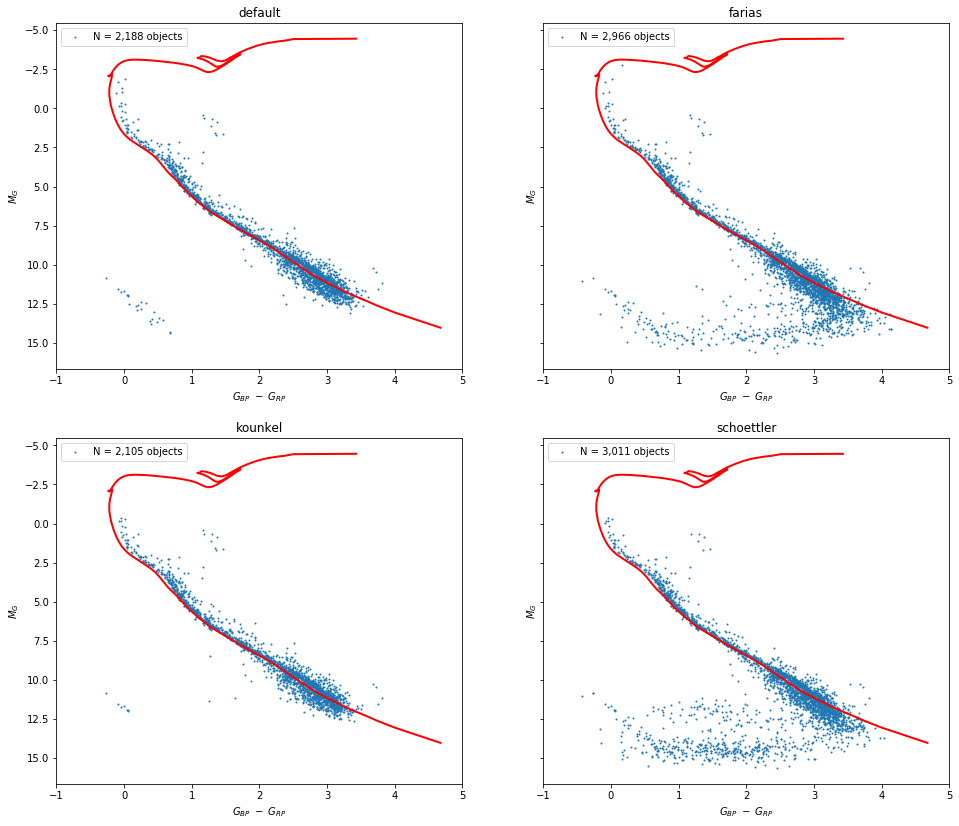

In [16]:
fig = plt.figure(figsize=(16,14))
ax = fig.subplots(2,2, sharey=True)

for i,con,a in zip(range(4), constraint_sets, ax.flatten()):
    N = len(constraint_results[con]['gs'].objs)
    constraint_results[con]['gs'].plot_hrdiagram(ax=a, title=con,
                                label=f'N = {N:,} objects')
    a.plot(isochrones['Pleiades']['G_BP']-isochrones['Pleiades']['G_RP'],
              isochrones['Pleiades']['G'], color='red', lw=2)
    a.legend()

In [17]:
for con in constraint_sets:
    print (f"Constraint: {con}, Number of Parallax <0: ",(constraint_results[con]['gs'].objs.parallax <0).sum())

Constraint: default, Number of Parallax <0:  0
Constraint: farias, Number of Parallax <0:  0
Constraint: kounkel, Number of Parallax <0:  0
Constraint: schoettler, Number of Parallax <0:  0


In [18]:
schoettler2_constraints = [
    '(({schema}.gaia_source.astrometric_excess_noise < 1) or (({schema}.gaia_source.astrometric_excess_noise> 1) and ({schema}.gaia_source.astrometric_excess_noise_sig <2)))',
    '{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',
    '{schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',    
    '{schema}.ruwe.ruwe < 1.3'
]

In [19]:
constraint_sets = { 'schoettler': schoettler_constraints, 'schoettler2': schoettler2_constraints}

cl = 'Pleiades'
ra_offset =  0*u.degree
dec_offset = 0*u.degree
search_radius = 5.0*u.degree
parallax=(6.25,10.0)

ra = cluster_info.loc[cl]['coords'].ra + ra_offset
dec = cluster_info.loc[cl]['coords'].dec + dec_offset

constraint_results = {}
for c in constraint_sets:
    
    #grab some stars around the cluster center
    fs = gs(name=f'source {c}', description=c)
    fs.set_gaia_source_constraints(constraint_sets[c])

    fs.conesearch(ra, dec, search_radius, parallax=parallax, schema='gaiadr2')
    
    constraint_results[c] = {'tap_query_string': fs.tap_query_string,
                         'RecordsReturned': len(fs.objs),
                             'gs': fs
                        } 
    print(fs)

INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: source schoettler, Description: schoettler, 3011 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: source schoettler2, Description: schoettler2, 2529 objects


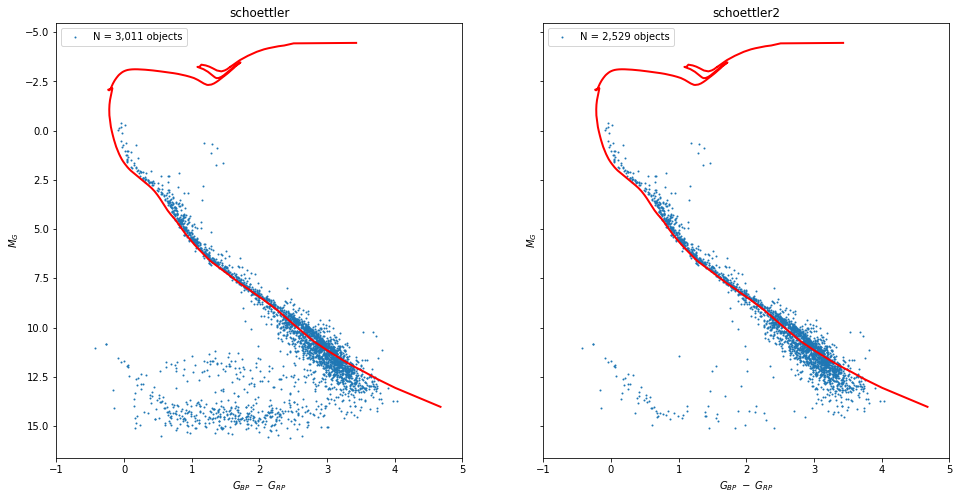

In [20]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2, sharey=True)

for i,con,a in zip(range(4), constraint_sets, ax.flatten()):
    N = len(constraint_results[con]['gs'].objs)
    constraint_results[con]['gs'].plot_hrdiagram(ax=a, title=con,
                                label=f'N = {N:,} objects')
    a.plot(isochrones['Pleiades']['G_BP']-isochrones['Pleiades']['G_RP'],
          isochrones['Pleiades']['G'], color='red', lw=2)
    a.legend()

## Gaia Early DR3

In [21]:
schoettler_constraints_dr3 = [
    '(({schema}.gaia_source.astrometric_excess_noise < 1) or (({schema}.gaia_source.astrometric_excess_noise> 1) and ({schema}.gaia_source.astrometric_excess_noise_sig <2)))',
    '{schema}.gaia_source.ruwe < 1.3'
]

schoettler2_constraints_dr3 = [
    '(({schema}.gaia_source.astrometric_excess_noise < 1) or (({schema}.gaia_source.astrometric_excess_noise> 1) and ({schema}.gaia_source.astrometric_excess_noise_sig <2)))',
    '{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',
    '{schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',    
    '{schema}.gaia_source.ruwe < 1.3'
]

In [56]:
constraint_sets = { 'schoettler_dr3': schoettler_constraints_dr3, 'schoettler2_dr3': schoettler2_constraints_dr3}

cl = 'Pleiades'
ra_offset =  0*u.degree
dec_offset = 0*u.degree
search_radius = 15.0*u.degree
parallax=(6.25,10.0)

ra = cluster_info.loc[cl]['coords'].ra + ra_offset
dec = cluster_info.loc[cl]['coords'].dec + dec_offset

constraint_results_dr3 = {}
for c in constraint_sets:
    
    #grab some stars around the cluster center
    fs = gs(name=f'source {c}', description=c)
    fs.set_gaia_source_constraints(constraint_sets[c])

    fs.conesearch(ra, dec, search_radius, parallax=parallax, schema='gaiaedr3')
    
    constraint_results_dr3[c] = {'tap_query_string': fs.tap_query_string,
                         'RecordsReturned': len(fs.objs),
                             'gs': fs
                        } 
    print(fs)

INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: source schoettler_dr3, Description: schoettler_dr3, 14959 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: source schoettler2_dr3, Description: schoettler2_dr3, 13439 objects


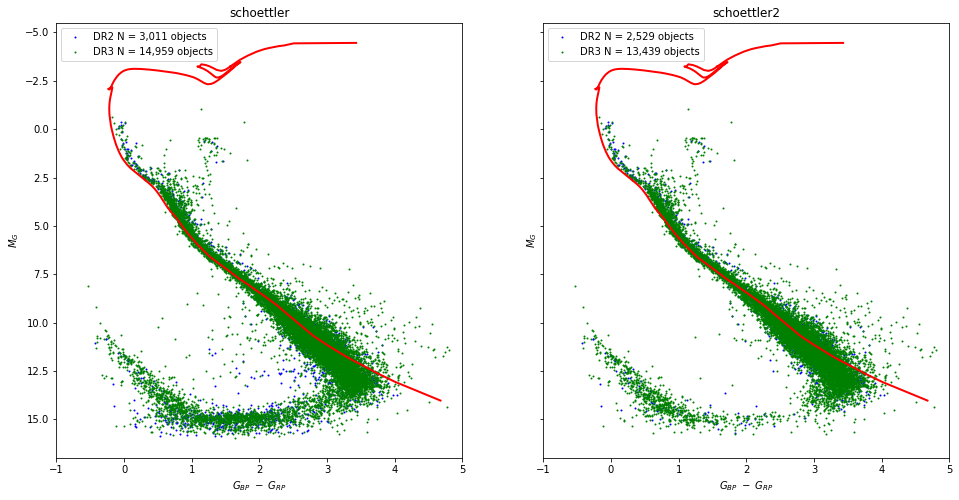

In [57]:
cs = [ 'schoettler', 'schoettler2']

fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2, sharey=True)

for i,con,a in zip(range(4), cs, ax.flatten()):
    N3 = len(constraint_results_dr3[f'{con}_dr3']['gs'].objs)
    N2 = len(constraint_results[con]['gs'].objs)
    constraint_results[con]['gs'].plot_hrdiagram(ax=a, title=con, r_est=False,
                            label=f'DR2 N = {N2:,} objects',color='blue')
    constraint_results_dr3[f'{con}_dr3']['gs'].plot_hrdiagram(ax=a, title=con, r_est=False,
                                label=f'DR3 N = {N3:,} objects',color='green')
    a.plot(isochrones['Pleiades']['G_BP']-isochrones['Pleiades']['G_RP'],
          isochrones['Pleiades']['G'], color='red', lw=2)
    a.legend()

In [24]:
constraint_sets

{'schoettler_dr3': ['(({schema}.gaia_source.astrometric_excess_noise < 1) or (({schema}.gaia_source.astrometric_excess_noise> 1) and ({schema}.gaia_source.astrometric_excess_noise_sig <2)))',
  '{schema}.gaia_source.ruwe < 1.3'],
 'schoettler2_dr3': ['(({schema}.gaia_source.astrometric_excess_noise < 1) or (({schema}.gaia_source.astrometric_excess_noise> 1) and ({schema}.gaia_source.astrometric_excess_noise_sig <2)))',
  '{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',
  '{schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',
  '{schema}.gaia_source.ruwe < 1.3']}

In [25]:
fs = gs(name='hunt for brown dwarfs')

In [28]:
cons = fs.set_gaia_source_constraints(None)

In [29]:
cons

['{schema}.gaia_source.parallax_over_error > 10',
 '{schema}.gaia_source.phot_g_mean_flux_over_error>50',
 '{schema}.gaia_source.phot_rp_mean_flux_over_error>20',
 '{schema}.gaia_source.phot_bp_mean_flux_over_error>20',
 '{schema}.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',
 '{schema}.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power({schema}.gaia_source.phot_bp_mean_mag-{schema}.gaia_source.phot_rp_mean_mag,2)',
 '{schema}.gaia_source.visibility_periods_used>8',
 '{schema}.gaia_source.astrometric_chi2_al/({schema}.gaia_source.astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*({schema}.gaia_source.phot_g_mean_mag-19.5)))']

In [58]:
bd_cons = ['{schema}.gaia_source.bp_rp > 3']


cl = 'Pleiades'
ra_offset =  0*u.degree
dec_offset = 0*u.degree
search_radius = 15.0*u.degree
parallax=(6.25,10.0)

ra = cluster_info.loc[cl]['coords'].ra + ra_offset
dec = cluster_info.loc[cl]['coords'].dec + dec_offset
fs = gs(name='hunt for brown dwarfs')
fs.set_gaia_source_constraints(bd_cons)
fs.conesearch(ra, dec, search_radius, parallax=parallax, schema='gaiaedr3')

print(fs)

INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: hunt for brown dwarfs, 5083 objects


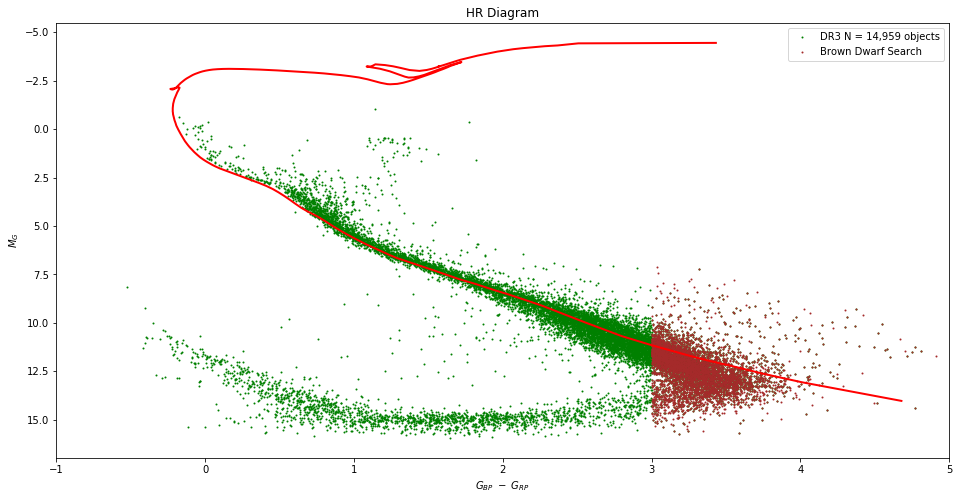

In [59]:
cs = [ 'schoettler', 'schoettler2']

fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,1)

N3 = len(constraint_results_dr3[f'schoettler_dr3']['gs'].objs)
#fs.plot_hrdiagram(ax=ax, r_est=False, label='Brown Dwarf Search', color='brown')
constraint_results_dr3[f'schoettler_dr3']['gs'].plot_hrdiagram(ax=ax, title=con, r_est=False,
                            label=f'DR3 N = {N3:,} objects',color='green')
fs.plot_hrdiagram(ax=ax, r_est=False, label='Brown Dwarf Search', color='brown')
ax.plot(isochrones['Pleiades']['G_BP']-isochrones['Pleiades']['G_RP'],
      isochrones['Pleiades']['G'], color='red', lw=2)
ax.legend()

In [60]:
#how many new ones?
merged_fs = constraint_results_dr3[f'schoettler_dr3']['gs'].merge(fs)

In [61]:
merged_fs.objs.which.value_counts()

source schoettler_dr3    10764
both                      4195
hunt for brown dwarfs      888
Name: which, dtype: int64

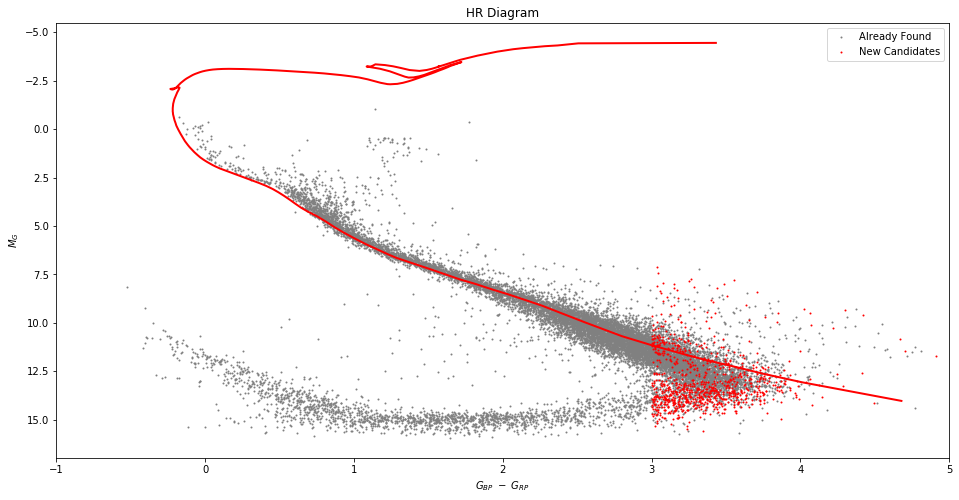

In [64]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,1)

merged_fs.query('which != \'hunt for brown dwarfs\'').plot_hrdiagram(ax=ax, color = 'gray', r_est=False, label='Already Found')
merged_fs.query('which == \'hunt for brown dwarfs\'').plot_hrdiagram(ax=ax, color = 'red', r_est=False, label='New Candidates')

ax.plot(isochrones['Pleiades']['G_BP']-isochrones['Pleiades']['G_RP'],
      isochrones['Pleiades']['G'], color='red', lw=2)
ax.legend()

In [63]:
fs.tap_query_string

"SELECT  gaiaedr3.gaia_source.source_id, gaiaedr3.gaia_source.ra, gaiaedr3.gaia_source.dec, gaiaedr3.gaia_source.parallax, gaiaedr3.gaia_source.pmra, gaiaedr3.gaia_source.pmdec, gaiaedr3.gaia_source.dr2_radial_velocity, gaiaedr3.gaia_source.phot_g_mean_mag, gaiaedr3.gaia_source.phot_bp_mean_mag, gaiaedr3.gaia_source.phot_rp_mean_mag FROM gaiaedr3.gaia_source WHERE CONTAINS(POINT('', ra, dec),  CIRCLE('', 56.75009432548025, 24.11647057028541, 15.0)) = 1  AND gaiaedr3.gaia_source.bp_rp > 3 AND parallax >= 6.25 AND parallax <= 10.0"

## References

<a id='GaiaA'></a> **Gaia A**: _Gaia Data Release 2: Observational Hertzsprung-Russell diagrams;_ Gaia Colaboration 2018 ([paper](https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html))

<a id='GaiaDM'></a> **Gaia DM**: _14.1.1 gaia_source_ Data Model Description; ([data model documentation](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html))

<a id='Farias2020'></a>**Farias 2020** : _Hunting for Runaways from the Orion Nebula Cluster;_ JUAN P. FARIAS, JONATHAN C. TAN, AND LAURENT EYER. ([paper](https://arxiv.org/pdf/2005.04762.pdf))

<a id='Schoettler2020'></a>**Schoettler 2020**: _Runaway and walkaway stars from the ONC with Gaia DR2;_ Christina Schoettler, Jos de Bruijne, Eero Vaher, Richard J. Parker. ([paper](https://arxiv.org/pdf/2004.13730.pdf))
